In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import re
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from collections import defaultdict
from collections import Counter, ChainMap

from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# Import data set:

In [2]:
pd.options.mode.chained_assignment = None

with open('data/dk_asylum_data.json', encoding='utf-8') as inputfile:
    df_full = pd.read_json(inputfile)

# Convert json to csv:
df_full.to_csv('data/dk_asylum_data.csv', encoding='utf-8', index=False)

df_full.shape


(9324, 5)

# Data preprocessing:

## Keep ALL cases EXCEPT for Unknown Homeland (Ukendt hjemland):

In [4]:
df_ALL = df_full[df_full.country != "Ukendt hjemland"]

# Drop redundant column:
df_ALL.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_ALL[['text']]

df["text"] = df["text"].astype(str)

df.shape

#df.head()


(9132, 1)

## Lower casing:

In [5]:
df["text_lower"] = df["text"].str.lower()
df.head()


,text,text_lower
0,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...
1,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...
2,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...
3,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...
4,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...


## Punctuation removal:

In [6]:
PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


df["text_wo_punct"] = df["text_lower"].apply(
    lambda text: remove_punctuation(text))
df.head()


,text,text_lower,text_wo_punct
0,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...
1,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...
2,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...
3,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...
4,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...


## Stopwords removal:

In [7]:
stopwords_lower = list(map(lambda x: x.lower(), stopwords.words('danish')))

STOPWORDS_DANISH = set(stopwords_lower)


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if not word in STOPWORDS_DANISH])


df["text_wo_stop"] = df["text_wo_punct"].apply(
    lambda text: remove_stopwords(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop
0,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...
1,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...
2,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...
3,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...
4,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede i marts 2022 udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...


## Numbers removal:

In [8]:
# Drop the columns which are no longer needed:
df.drop(["text_lower", 'text_wo_punct'], axis=1, inplace=True)


def drop_numbers(text):
    text_wo_numbers = re.sub(r'[0-9]+', '', text)
    return text_wo_numbers


df["text_wo_numbers"] = df["text_wo_stop"].apply(
    lambda text: drop_numbers(text))
df.head()


,text,text_wo_stop,text_wo_numbers
0,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...
1,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...
2,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...
3,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...
4,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...


## Single character words removal:

In [9]:
def drop_single_letter_words(text):
    return ' '.join([w for w in text.split() if len(w) > 1])


df["text_wo_single_letters"] = df["text_wo_numbers"].apply(
    lambda text: drop_single_letter_words(text))
df.head()


,text,text_wo_stop,text_wo_numbers,text_wo_single_letters
0,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...,nævnet stadfæstede marts udlændingestyrelsens ...
1,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...,nævnet stadfæstede marts udlændingestyrelsens ...
2,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...,nævnet stadfæstede marts udlændingestyrelsens ...
3,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...,nævnet stadfæstede marts udlændingestyrelsens ...
4,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts 2022 udlændingestyrel...,nævnet stadfæstede marts udlændingestyrelsens...,nævnet stadfæstede marts udlændingestyrelsens ...


## Tokenize text:

In [10]:
# Drop the columns which are no longer needed
df.drop(["text_wo_stop", 'text_wo_numbers'], axis=1, inplace=True)

nlp = spacy.load("da_core_news_sm")


def tokenize_text(text):
    doc = nlp.tokenizer(text)
    return ' '.join([token.text for token in doc])


df["text_tokenized"] = df["text_wo_single_letters"].apply(
    lambda text: tokenize_text(text))

df.head()


,text,text_wo_single_letters,text_tokenized
0,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...
1,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...
2,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...
3,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...
4,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...


## Lemmatization:

In [11]:
def lemmatize_words(text):
    """custom function to lemmatize text"""
    doc = nlp(text)
    # pos_tagged_text = text.pos
    return ' '.join([token.lemma_ for token in doc])


df["text_lemmatized"] = df["text_tokenized"].apply(
    lambda text: lemmatize_words(text))
df.head()


,text,text_wo_single_letters,text_tokenized,text_lemmatized
0,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...,nævn stadfæste marts udlændingestyrelse afgøre...
1,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...,nævn stadfæste marts udlændingestyrelse afgøre...
2,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...,nævn stadfæste marts udlændingestyrelse afgøre...
3,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...,nævn stadfæste marts udlændingestyrelse afgøre...
4,Nævnet stadfæstede i marts 2022 Udlænd...,nævnet stadfæstede marts udlændingestyrelsens ...,nævnet stadfæstede marts udlændingestyrelsens ...,nævn stadfæste marts udlændingestyrelse afgøre...


## No-sense words removal:

In [12]:
df.drop(["text_wo_single_letters", 'text_tokenized'], axis=1, inplace=True)

# Using spacy’s pos_ attribute, we can check if a particular token
# is junk (i.e do not mean anything) through token.pos_ == 'X' and remove them.


def remove_junk(text):
    # Creating a spacy object
    doc = nlp(text)
    # Checking if POS tag is X and printing them
    for token in doc:
        if token.pos_ == 'X':
            print(token.text)
    # Removing the tokens whose POS tag is junk.
    clean_doc = [token.text for token in doc if not token.pos_ == 'X']

    return ' '.join(clean_doc)


df['no_junk'] = df["text_lemmatized"].apply(lambda text: remove_junk(text))

df.head()


jf
asyl
møde
eus
jf
overførsel
jf
asyl
jf
jf
asyl
jf
asyl
jf
jf
asyl
hjælpe
udsende
indkvartere
acces
jf
jf
schweiz
følge
eus
jf
jf
tyskland
jf
jf
asyl
mindreårig
jf
jf
eus
jf
fremgå
gælde
føde
in
the
governorate
of
be
of
indiscriminate
within
the
of
article
and
in
the
governorates
of
and
when
the
of
all
in
and
in
the
you
your
md
and
tag
følge
følge
afstemme
gå
hense
udlændingelov
følge
følge
and
return
in
and
udlændingelov
adskille
sen
møde
erstatningskrav
stressfulde
udvise
udrejse
måned
måned
ønske
koldings
udvise
bla
dømme
irak
måned
tag
tag
tag
tyrk
tilknytte
forøge
hjælpe
genindkalde
anmodning
tag
møde
udlændingelov
jf
stress
følge
afgive
tag
oplyse
oplyse
tag
oplyse
idømme
idømme
tag
smide
tåregas
tag
tag
firefem
gå
tag
tag
trefire
møde
oplyse
oplyse
måned
bryde
bøde
foreholde
jf
modtageforhold
spain
udsende
læg
acces
fornøden
syn
lægge
antage
jf
idømme
følge
udlændingelov
für
udlænding
für
udlænding
navnlig
forsigtighedsprincip
asyl
udlænding
fremgå
måned
tag
længde
tag
følge
g

,text,text_lemmatized,no_junk
0,Nævnet stadfæstede i marts 2022 Udlænd...,nævn stadfæste marts udlændingestyrelse afgøre...,nævn stadfæste marts udlændingestyrelse afgøre...
1,Nævnet stadfæstede i marts 2022 Udlænd...,nævn stadfæste marts udlændingestyrelse afgøre...,nævn stadfæste marts udlændingestyrelse afgøre...
2,Nævnet stadfæstede i marts 2022 Udlænd...,nævn stadfæste marts udlændingestyrelse afgøre...,nævn stadfæste marts udlændingestyrelse afgøre...
3,Nævnet stadfæstede i marts 2022 Udlænd...,nævn stadfæste marts udlændingestyrelse afgøre...,nævn stadfæste marts udlændingestyrelse afgøre...
4,Nævnet stadfæstede i marts 2022 Udlænd...,nævn stadfæste marts udlændingestyrelse afgøre...,nævn stadfæste marts udlændingestyrelse afgøre...


# Analysis:

## N-gram analysis:

**N-grams** are neighboring sequences of items (words, letters, symbols) in a document. 

Most of the times a probability is assigned to the occurrence of a N-gram (or a word occurring next in a sequence of words). This can help decide which N-grams can be chunked together to form single entities or make predictions for next words (other possible use cases include spelling corrections).  

[Here](https://web.stanford.edu/~jurafsky/slp3/slides/LM_4.pdf), are some slides from Stanford which provide an introduction to N-gram models and the math that goes with it. 

In [13]:
def generate_N_grams(text, ngram=1):
    """"custom function to generate n-grams"""
    words = [word for word in text.split(
        " ") if word not in set(STOPWORDS_DANISH)]
    # print("Sentence after removing stopwords:", words)
    # Use the zip function to help us generate n-grams
    temp = zip(*[words[i:] for i in range(0, ngram)])
    # Concatentate the tokens into ngrams and return
    ans = [' '.join(ngram) for ngram in temp]
    return ans


values = defaultdict(int)

# Get the count of every bigram in the data set from last processed column:
for text in df['no_junk']:
    for word in generate_N_grams(text, 2):
        values[word] += 1


In [14]:
# Focus on more frequently occuring words.
# Sort in descending order with respect to the column of interest:
df_processed = pd.DataFrame(
    sorted(values.items(), key=lambda x: x[1], reverse=True))

# Ten first values of the first column:
c1 = df_processed[0][:10]
# Ten first values of the second column:
c2 = df_processed[1][:10]


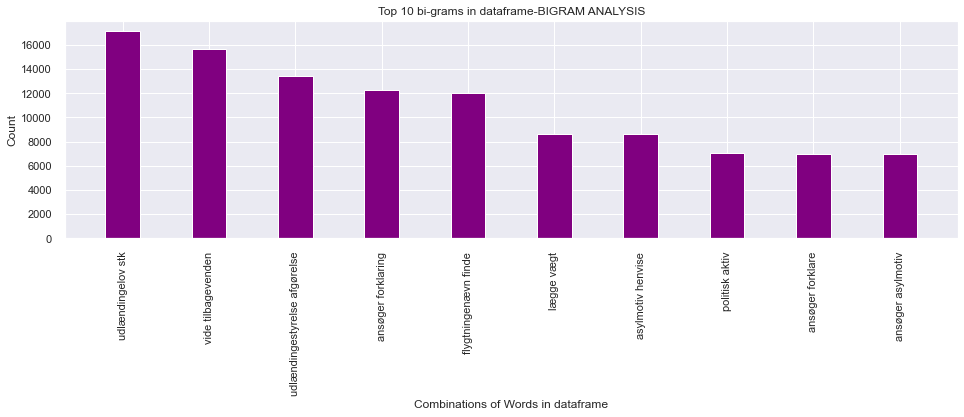

In [15]:
plt.figure(1, figsize=(16, 4))
plt.bar(c1, c2, color='purple',
        width=0.4)
plt.xlabel("Combinations of Words in dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 bi-grams in dataframe-BIGRAM ANALYSIS")
# plt.savefig("dataset-bigram.png")
plt.show()


## TF-IDF

**Term Frequency (TF):**

The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

A value close to 1 indicates this term is very important to the document — and primarily composed of it. A low value could mean this term is not very important.

**Inverse Data Frequency (IDF):**

The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

A value close to 0 indicates the term is very common — and not very helpful in differentiating this document from another. A higher value indicates the term is not very common and could be crucial to understanding the theme of this document.

The **TF-IDF** is the multiplication of TF by IDF.

A value close to 0 indicates the term is not important either in the corpus or the document or both. A larger value indicates the term is unique for the document or the corpus or both. This value works best in relation to other terms in the same document, and other documents.

In [27]:
# Get the column of interest:
docs = df['no_junk'].tolist()

# Create a vocabulary of words, ignore words that appear in 85% of documents,
# Eliminate stop words if any, limit features to 10000:
cv = CountVectorizer(max_df=0.85, stop_words=STOPWORDS_DANISH, max_features=10000)
word_count_vector = cv.fit_transform(docs)

# Get shape of resulting vector:
word_count_vector.shape


(9132, 10000)

In [28]:
word_count_vector = cv.fit_transform(docs)

# Look at 10 words from our vocabulary:
list(cv.vocabulary_.keys())[:10]


['stadfæste',
 'marts',
 'udlændingestyrelse',
 'afgørelse',
 'overførsel',
 'letland',
 'medføre',
 'pkt',
 'jf',
 'dublinforordningen']

In [29]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

# Look at the IDF values:
tfidf_transformer.idf_


array([8.17373936, 9.42650233, 7.48059218, ..., 7.72175423, 6.56430145,
       1.33334563])

In [31]:
# Sorts the values in the vector while preserving the column index
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_top_n_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""

    # Use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]

        # Keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(fname)

    # Create a tuples of feature,score
    # results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results


In [32]:
# We only need to do this once:
feature_names = cv.get_feature_names_out()

# Generate tf-idf for all documents in list. docs has 192 documents:
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs))

results = []
for i in range(tf_idf_vector.shape[0]):

    # get vector for a single document
    curr_vector = tf_idf_vector[i]

    # sort the tf-idf vector by descending order of scores
    sorted_items = sort_coo(curr_vector.tocoo())

    # extract only the top n; n here is 10
    keywords = extract_top_n_from_vector(feature_names, sorted_items, 10)

    results.append(keywords)

df_tfIDF = pd.DataFrame(zip(docs, results), columns=['doc', 'keywords'])
# df_tfIDF.shape
df_tfIDF


,doc,keywords
0,nævn stadfæste marts udlændingestyrelse afgøre...,"{'letland': 0.873, 'klager': 0.193, 'forordnin..."
1,nævn stadfæste marts udlændingestyrelse afgøre...,"{'nederlandene': 0.696, 'klager': 0.313, 'dubl..."
2,nævn stadfæste marts udlændingestyrelse afgøre...,"{'østrig': 0.539, 'klager': 0.468, 'dublinforo..."
3,nævn stadfæste marts udlændingestyrelse afgøre...,"{'tyskland': 0.545, 'klager': 0.406, 'forordni..."
4,nævn stadfæste marts udlændingestyrelse afgøre...,"{'spanien': 0.598, 'asylansøger': 0.277, 'klag..."
...,...,...
9127,nævn stadfæste februar udlændingestyrelse afgø...,"{'taleban': 0.436, 'afghanistan': 0.25, 'afgha..."
9128,nævn meddele marts opholdstilladelse kstatus æ...,"{'genoptage': 0.244, 'udadvendt': 0.233, 'kuns..."
9129,nævn meddele januar opholdstilladelse kstatus ...,"{'rang': 0.373, 'khad': 0.369, 'dostum': 0.259..."
9130,nævn meddele marts opholdstilladelse fstatus æ...,"{'afghanistan': 0.484, 'ansøge': 0.293, 'taleb..."


In [35]:
# Create a dictionary from results list of dictionaries:
my_dict = dict(ChainMap(*results))

c = Counter(my_dict)

# Returns top 20 most common pairs:
most_common = c.most_common(20)

# For getting the keys from `most_common`:
my_keys = [key for key, val in most_common]

print(most_common)


[('gulbuddin', 0.918), ('honduras', 0.893), ('letland', 0.873), ('studiekammerat', 0.85), ('gaza', 0.846), ('rwanda', 0.841), ('gülenbevægelsen', 0.839), ('litauen', 0.837), ('cypern', 0.824), ('xbevægelsen', 0.821), ('sydsudan', 0.818), ('aslægten', 0.812), ('cndp', 0.81), ('ezmary', 0.808), ('tunesien', 0.805), ('galadiklanen', 0.805), ('nordalliancen', 0.803), ('murad', 0.803), ('fatima', 0.795), ('aziz', 0.793)]


## Topic Modelling:

Using Latent Dirichlet Allocation (LDA)

For a given corpus, a topic model estimates a topic distribution for each of its documents (i.e., a a distribution of weights over a set of topics), where a topic is itself a distribution of weights over the vocabulary of the corpus. The most weighted words of each topic are syntactically and/or semantically related, given that collection of documents. This means that two distinct topics share the exact same vocabulary, but have different weight distributions.

In [36]:
docs = [d.split() for d in docs]

# Create dictionary
dictionary = corpora.Dictionary(docs)

# Create document term matrix
bow = [dictionary.doc2bow(text) for text in docs]


Compute the coherence score is essentially a measure of how similar the words assigned to each topic are in terms of semantic value. The higher the score, the better.

Compute the coherence score for LDA models with 2 to 10 topics and see which number of topics leads to the highest coherence score.

Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases.

In [37]:
best_num = float('NaN')
best_score = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create lda model with i topics
    lda = LdaModel(corpus=bow, num_topics=i,
                   id2word=dictionary, random_state=42)

    # Obtain the coherence score
    coherence_model = CoherenceModel(
        model=lda, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_score = np.round(coherence_model.get_coherence(), 2)
    if coherence_score > best_score:
        best_num = i
        best_score = coherence_score

print(f'The coherence score ({best_score}) is highest with {best_num} topics.')


The coherence score (0.43) is highest with 6 topics.


In [38]:
# Build the lda model
lda_model = LdaModel(corpus=bow,
                     id2word=dictionary,
                     num_topics=best_num,
                     random_state=42)


# Show the words most strongly associated with each topic
for topic in lda_model.print_topics():
    print(topic)


(0, '0.089*"ansøger" + 0.020*"flygtningenævn" + 0.012*"vide" + 0.011*"forklare" + 0.011*"finde" + 0.010*"nævn" + 0.009*"forklaring" + 0.009*"familie" + 0.007*"grund" + 0.007*"asylmotiv"')
(1, '0.075*"ansøger" + 0.022*"afghanistan" + 0.019*"taliban" + 0.016*"flygtningenævn" + 0.010*"vide" + 0.009*"finde" + 0.008*"grund" + 0.008*"familie" + 0.008*"mandlig" + 0.008*"nævn"')
(2, '0.026*"flygtningenævn" + 0.020*"udlændingelov" + 0.018*"stk" + 0.018*"klager" + 0.014*"opholdstilladelse" + 0.014*"forhold" + 0.013*"finde" + 0.012*"ansøger" + 0.012*"nævn" + 0.010*"grund"')
(3, '0.036*"klager" + 0.021*"flygtningenævn" + 0.017*"stk" + 0.016*"syrien" + 0.016*"opholdstilladelse" + 0.014*"udlændingelov" + 0.011*"udlændingestyrelse" + 0.010*"ansøger" + 0.009*"grund" + 0.009*"vide"')
(4, '0.084*"ansøger" + 0.024*"flygtningenævn" + 0.014*"vide" + 0.012*"finde" + 0.011*"grund" + 0.011*"iran" + 0.011*"nævn" + 0.009*"forklaring" + 0.009*"myndighed" + 0.008*"lægge"')
(5, '0.034*"klager" + 0.025*"somalia" + 

In [39]:
# Visualize LDA model results
pyLDAvis.enable_notebook()

gensim_models.prepare(lda_model, dictionary=dictionary, corpus=bow)


/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.057548 -0.014376       1        1  38.532336
4     -0.051320 -0.020913       2        1  20.664850
2      0.080334 -0.051548       3        1  11.816549
3      0.066720  0.010079       4        1  10.706951
1     -0.080136  0.013531       5        1  10.431991
5      0.041950  0.063227       6        1   7.847323, topic_info=             Term           Freq          Total Category  logprob  loglift
353       ansøger  189366.000000  189366.000000  Default  30.0000  30.0000
71         klager   27521.000000   27521.000000  Default  29.0000  29.0000
5872  afghanistan   12718.000000   12718.000000  Default  28.0000  28.0000
1616      somalia    8096.000000    8096.000000  Default  27.0000  27.0000
5885      taliban    7332.000000    7332.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
140        oplyse    1065.003635   13395.921776   Topic6  -5.4066   0.0130
530      politisk    1083.544634   16480.708632   Topic6  -5.3894  -0.1770
117       udrejse    1039.888402   16688.598862   Topic6  -5.4305  -0.2306
2       afgørelse    1031.170508   17224.017399   Topic6  -5.4389  -0.2706
498        medlem     996.051782   12600.220260   Topic6  -5.4736   0.0073

[569 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
4921       1  0.085294    affatte
4921       2  0.024370    affatte
4921       3  0.846843    affatte
4921       4  0.024370    affatte
4921       6  0.012185    affatte
...      ...       ...        ...
13637      1  0.941320  øjenvidne
13637      2  0.024450  øjenvidne
13637      3  0.024450  øjenvidne
13637      4  0.012225  øjenvidne
13637      6  0.012225  øjenvidne

[2000 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2, 6])

Each bubble in the plot represents a topic. The size of the bubble represents the proportion of cases that contain the topic, with a larger bubble corresponding to a higher proportion. 

The distance between the bubbles represents the similarity between the topics; the shorter the distance, the more similar the topics.

The bars in the bar chart represent the term frequency for each of the words. The blue bars show the overall term frequency in the collection of documents, whereas the red bars show the term frequency for the selected topic.